In [68]:
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
data = get_CIFAR10_data()
for k, v in data.items():
    print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


Batch Nomalization: Forward
---

In [70]:
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)
print('Before batch normalization:')
print_mean_std(a, axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm, axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm, axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [ 2.22044605e-17 -3.77475828e-17  1.78329573e-17]
  stds:   [1. 1. 1.]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [1. 2. 3.]



In [71]:
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {}
bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
    x = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)
    
bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.02476963 -0.06763889 -0.15768056]
  stds:   [0.99309037 1.01167229 1.07889212]



Batch Nomalization: Backward
---

In [72]:
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fgamma = lambda gamma: batchnorm_forward(x, gamma, beta, bn_param)[0]
fbeta = lambda beta: batchnorm_forward(x, gamma, beta, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dgamma_num = eval_numerical_gradient_array(fgamma, gamma, dout)
dbeta_num = eval_numerical_gradient_array(fbeta, beta, dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(dgamma_num, dgamma))
print('dbeta error: ', rel_error(dbeta_num, dbeta))


dx error:  1.047097385008511e-09
dgamma error:  2.102691474551546e-12
dbeta error:  3.177933097315994e-12


In [73]:
np.random.seed(231)
N, D = 100, 500
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_params = {}
bn_params = {'mode': 'train'}
out, cache = batchnorm_forward(x, gamma, beta, bn_params)

t1 = time.time()
dx1, dgamma1, dbeta1 = batchnorm_backward(dout, cache)
t2 = time.time()
dx2, dgamma2, dbeta2 = batchnorm_backward_alt(dout, cache)
t3 = time.time()

print('dx difference: ', rel_error(dx1, dx2))
print('dgamma difference: ', rel_error(dgamma1, dgamma2))
print('dbeta difference: ', rel_error(dbeta1, dbeta2))
print('speedup: %.2fx' % ((t2 - t1) / (t3 - t2)))

dx difference:  1.7518613962328323e-12
dgamma difference:  0.0
dbeta difference:  0.0
speedup: 1.68x


Fully Connected Nets with Batch Normalization
---

In [74]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0.0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C, reg=reg, weight_scale=5e-2, normalization='batch_norm')
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
    
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0.0
Initial loss:  2.1630700255489845
W1 relative error: 3.19e-03
W2 relative error: 7.64e-04
W3 relative error: 3.39e-10
b1 relative error: 2.71e-12
b2 relative error: 2.78e-09
b3 relative error: 1.43e-10
beta1 relative error: 1.57e-05
beta2 relative error: 1.51e-09
gamma1 relative error: 1.53e-05
gamma2 relative error: 1.35e-09
Running check with reg =  3.14
Initial loss:  6.992464984987152
W1 relative error: 1.98e-08
W2 relative error: 8.22e-08
W3 relative error: 5.35e-09
b1 relative error: 5.42e-12
b2 relative error: 4.44e-08
b3 relative error: 1.62e-10
beta1 relative error: 3.39e-06
beta2 relative error: 7.43e-09
gamma1 relative error: 7.11e-06
gamma2 relative error: 8.08e-09


In [75]:
np.random.seed(231)
hidden_dims = [100, 100, 100, 100, 100]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batch_norm')
model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)

bn_solver = Solver(bn_model, small_data, num_epoch=10, batch_size=50, update_rule='adam', optim_config={'learning_rate': 1e-3})
bn_solver.train()

solver = Solver(model, small_data, num_epoch=10, batch_size=50, update_rule='adam', optim_config={'learning_rate': 1e-3})
solver.train()


Iteration 1 / 200 - loss: 2.338739
Epoch 0 / 10 - train acc: 0.107000; val_acc: 0.109000
Epoch 1 / 10 - train acc: 0.331000; val_acc: 0.278000
Epoch 2 / 10 - train acc: 0.460000; val_acc: 0.329000
Epoch 3 / 10 - train acc: 0.480000; val_acc: 0.340000
Epoch 4 / 10 - train acc: 0.580000; val_acc: 0.328000
Epoch 5 / 10 - train acc: 0.599000; val_acc: 0.321000
Iteration 101 / 200 - loss: 1.232848
Epoch 6 / 10 - train acc: 0.666000; val_acc: 0.318000
Epoch 7 / 10 - train acc: 0.737000; val_acc: 0.336000
Epoch 8 / 10 - train acc: 0.762000; val_acc: 0.302000
Epoch 9 / 10 - train acc: 0.788000; val_acc: 0.332000
Epoch 10 / 10 - train acc: 0.851000; val_acc: 0.340000
Epoch 10 / 10 - best_val_acc: 0.340000
Iteration 1 / 200 - loss: 2.303492
Epoch 0 / 10 - train acc: 0.146000; val_acc: 0.140000
Epoch 1 / 10 - train acc: 0.252000; val_acc: 0.234000
Epoch 2 / 10 - train acc: 0.275000; val_acc: 0.220000
Epoch 3 / 10 - train acc: 0.328000; val_acc: 0.269000
Epoch 4 / 10 - train acc: 0.378000; val_acc

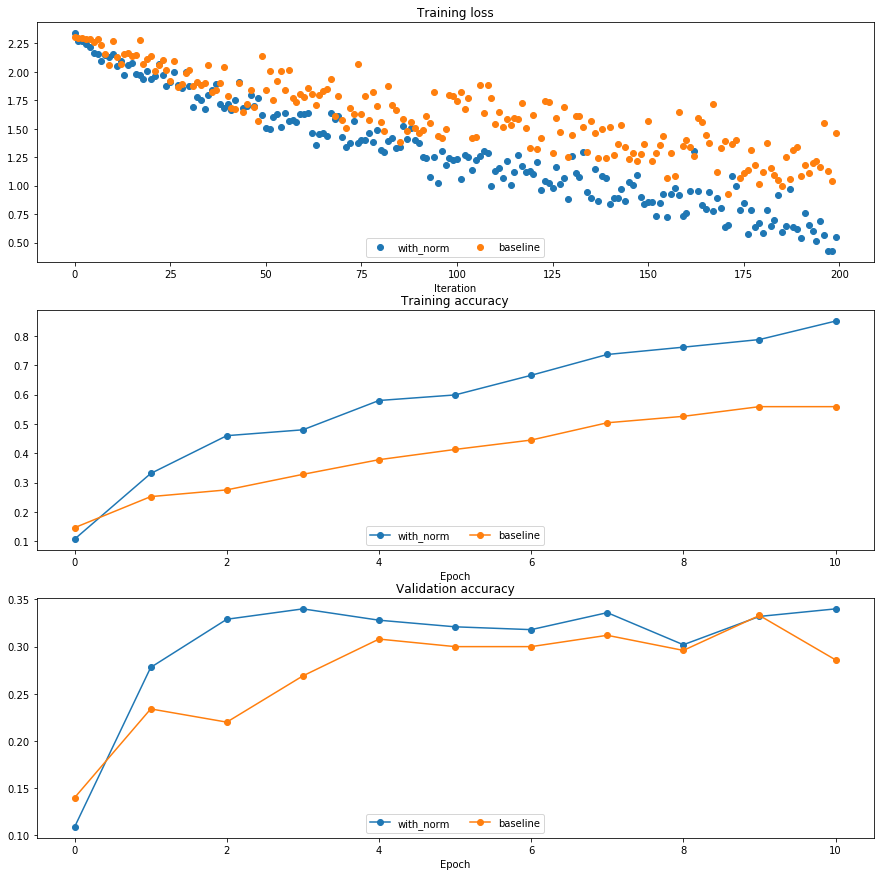

In [76]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1)

plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()    
    
    
        

Batch Normalization and Initialization
---

In [77]:
np.random.seed(231)
hidden_dims = [50, 50, 50, 50, 50, 50, 50]
num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

bn_solvers_ws = {}
solvers_ws = {}
weight_scales = np.logspace(-4, 0, num=20)
for i, weight_scale in enumerate(weight_scales):
    print('Running weight scale %d / %d' % (i + 1, len(weight_scales)))
    bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization='batch_norm')
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    
    bn_solver = Solver(bn_model, small_data, num_epoch=10, batch_size=50, 
                       update_rule='adam', optim_config={'learning_rate': 1e-3}, verbose=False)
    bn_solver.train()
    bn_solvers_ws[weight_scale] = bn_solver
    
    solver = Solver(model, small_data, num_epoch=10, batch_size=50, 
                    update_rule='adam', optim_config={'learning_rate': 1e-3}, verbose=False)
    solver.train()
    solvers_ws[weight_scale] = solver


Running weight scale 1 / 20
Epoch 10 / 10 - best_val_acc: 0.267000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 2 / 20
Epoch 10 / 10 - best_val_acc: 0.247000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 3 / 20
Epoch 10 / 10 - best_val_acc: 0.242000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 4 / 20
Epoch 10 / 10 - best_val_acc: 0.284000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 5 / 20
Epoch 10 / 10 - best_val_acc: 0.232000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 6 / 20
Epoch 10 / 10 - best_val_acc: 0.229000
Epoch 10 / 10 - best_val_acc: 0.119000
Running weight scale 7 / 20
Epoch 10 / 10 - best_val_acc: 0.261000
Epoch 10 / 10 - best_val_acc: 0.159000
Running weight scale 8 / 20
Epoch 10 / 10 - best_val_acc: 0.252000
Epoch 10 / 10 - best_val_acc: 0.190000
Running weight scale 9 / 20
Epoch 10 / 10 - best_val_acc: 0.295000
Epoch 10 / 10 - best_val_acc: 0.194000
Running weight scale 10 / 20
Epoch 10 / 10 - b

/home/lzhang/documentation/cs231n/code/cs231n/assignment2/cs231n/layers.py:246: RuntimeWarning: divide by zero encountered in log
  loss = -np.log(correct_exp_scores/np.sum(exp_scores, axis=1))


Epoch 10 / 10 - best_val_acc: 0.156000
Running weight scale 18 / 20
Epoch 10 / 10 - best_val_acc: 0.203000
Epoch 10 / 10 - best_val_acc: 0.134000
Running weight scale 19 / 20
Epoch 10 / 10 - best_val_acc: 0.162000
Epoch 10 / 10 - best_val_acc: 0.161000
Running weight scale 20 / 20
Epoch 10 / 10 - best_val_acc: 0.150000
Epoch 10 / 10 - best_val_acc: 0.144000


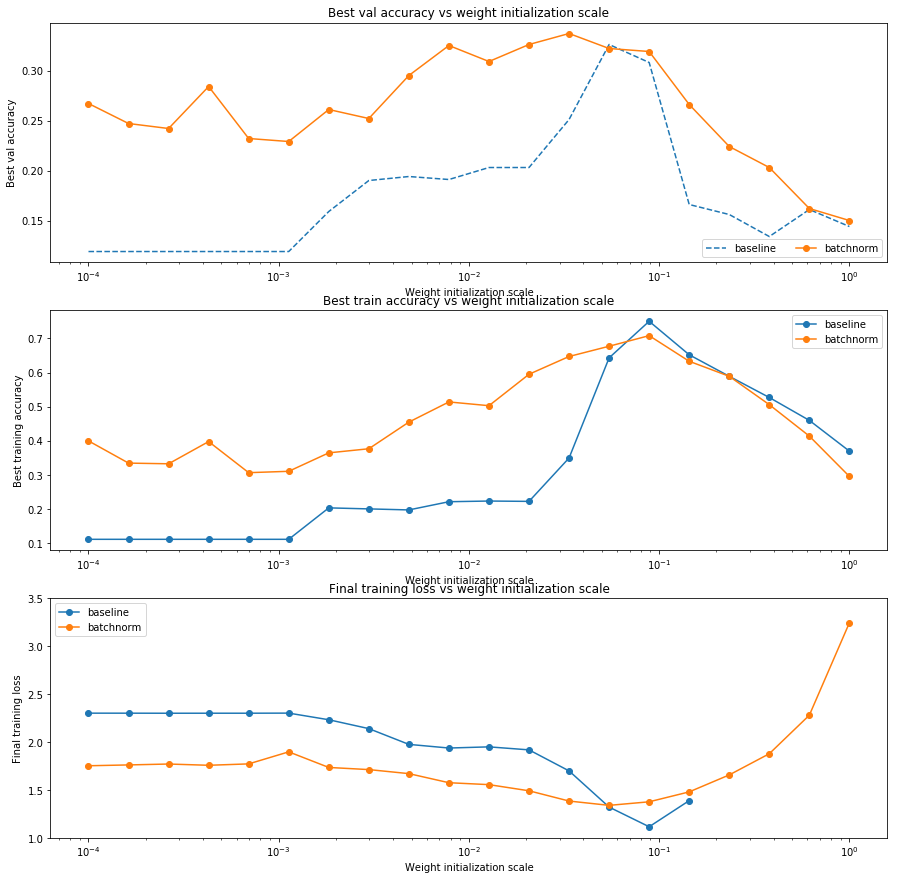

In [78]:
best_train_accs, bn_best_train_accs = [], []
best_val_accs, bn_best_val_accs = [], []
final_train_loss, bn_final_train_loss = [], []

for ws in weight_scales:
    best_train_accs.append(max(solvers_ws[ws].train_acc_history))
    bn_best_train_accs.append(max(bn_solvers_ws[ws].train_acc_history))

    best_val_accs.append(max(solvers_ws[ws].val_acc_history))
    bn_best_val_accs.append(max(bn_solvers_ws[ws].val_acc_history))

    final_train_loss.append(np.mean(solvers_ws[ws].loss_history[-100:]))
    bn_final_train_loss.append(np.mean(bn_solvers_ws[ws].loss_history[-100:]))
    
plt.subplot(3, 1, 1)
plt.title('Best val accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best val accuracy')
plt.semilogx(weight_scales, best_val_accs, '--', label='baseline')
plt.semilogx(weight_scales, bn_best_val_accs, '-o', label='batchnorm')
plt.legend(ncol=2, loc='lower right')

plt.subplot(3, 1, 2)
plt.title('Best train accuracy vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Best training accuracy')
plt.semilogx(weight_scales, best_train_accs, '-o', label='baseline')
plt.semilogx(weight_scales, bn_best_train_accs, '-o', label='batchnorm')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Final training loss vs weight initialization scale')
plt.xlabel('Weight initialization scale')
plt.ylabel('Final training loss')
plt.semilogx(weight_scales, final_train_loss, '-o', label='baseline')
plt.semilogx(weight_scales, bn_final_train_loss, '-o', label='batchnorm')
plt.legend()
plt.gca().set_ylim(1.0, 3.5)

plt.gcf().set_size_inches(15, 15)
plt.show()

Batch Normalization and Batch Size
---

In [79]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]
    
    print('No normalization: batch size = ', solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epoch=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, reg=0.0, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epoch=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batch_norm')

No normalization: batch size =  5
Epoch 10 / 10 - best_val_acc: 0.321000
Normalization: batch size =  5
Epoch 10 / 10 - best_val_acc: 0.314000
Normalization: batch size =  10
Epoch 10 / 10 - best_val_acc: 0.320000
Normalization: batch size =  50
Epoch 10 / 10 - best_val_acc: 0.340000


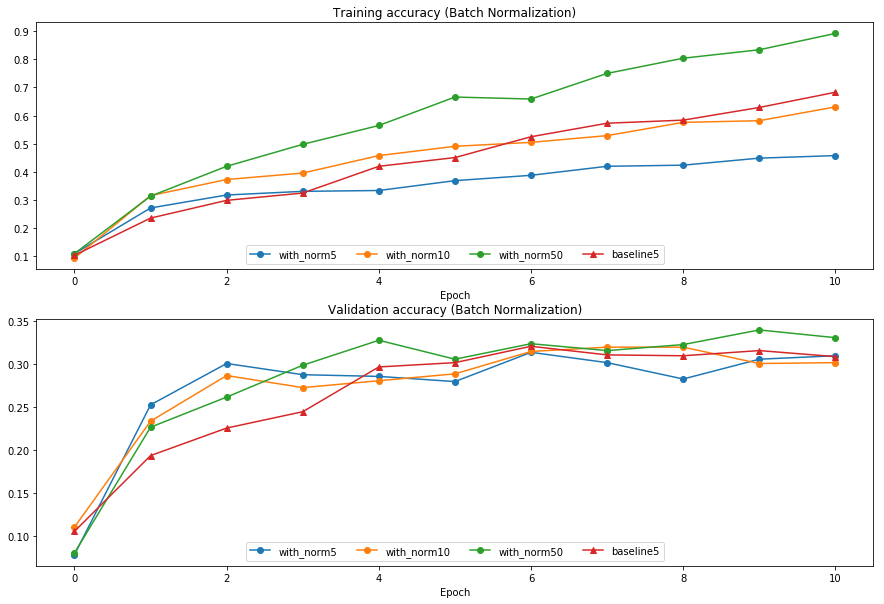

In [80]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

Layer Normalization
---

In [81]:
np.random.seed(231)
N, D1, D2, D3 =4, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before layer normalization:')
print_mean_std(a,axis=1)

gamma = np.ones(D3)
beta = np.zeros(D3)
a_norm, _ = layernorm_forward(a, gamma, beta)
print_mean_std(a_norm,axis=1)
gamma = np.asarray([3.0,3.0,3.0])
beta = np.asarray([5.0,5.0,5.0])
print('After layer normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = layernorm_forward(a, gamma, beta)
print_mean_std(a_norm,axis=1)

Before layer normalization:
  means:  [-59.06673243 -47.60782686 -43.31137368 -26.40991744]
  stds:   [10.07429373 28.39478981 35.28360729  4.01831507]

  means:  [-2.22044605e-16  0.00000000e+00 -1.48029737e-16 -2.96059473e-16]
  stds:   [1. 1. 1. 1.]

After layer normalization (gamma= [3. 3. 3.] , beta= [5. 5. 5.] )
  means:  [5. 5. 5. 5.]
  stds:   [3. 3. 3. 3.]



In [82]:
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

ln_param = {}
fx = lambda x: layernorm_forward(x, gamma, beta, ln_param)[0]
fg = lambda a: layernorm_forward(x, a, beta, ln_param)[0]
fb = lambda b: layernorm_forward(x, gamma, b, ln_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = layernorm_forward(x, gamma, beta, ln_param)
dx, dgamma, dbeta = layernorm_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.0574979452402554e-09
dgamma error:  3.21691412757953e-12
dbeta error:  2.276445013433725e-12


Layer Normalization and Batch Size
---

No normalization: batch size =  5
Epoch 10 / 10 - best_val_acc: 0.321000
Normalization: batch size =  5
Epoch 10 / 10 - best_val_acc: 0.349000
Normalization: batch size =  10
Epoch 10 / 10 - best_val_acc: 0.352000
Normalization: batch size =  50
Epoch 10 / 10 - best_val_acc: 0.339000


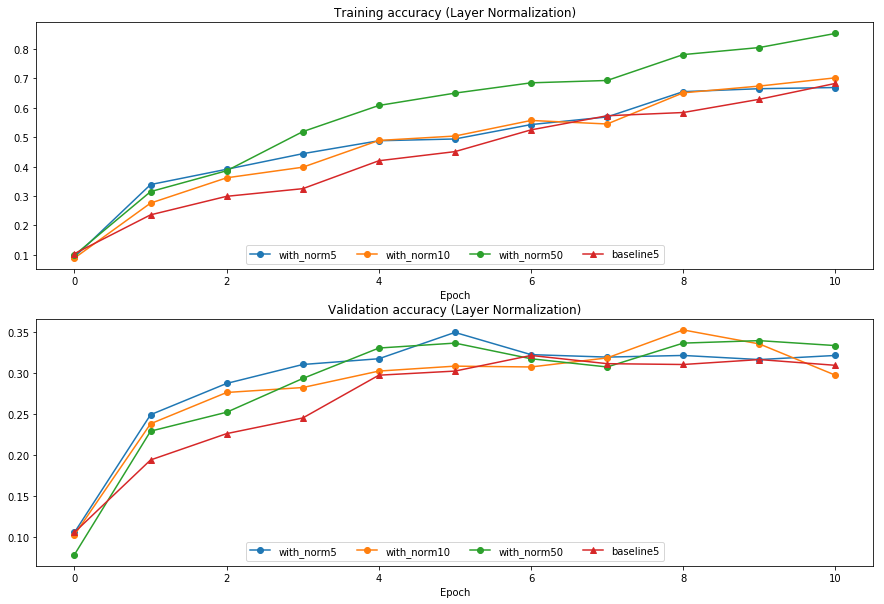

In [83]:
ln_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('layer_norm')
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Layer Normalization)','Epoch', solver_bsize, ln_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()